In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libs


In [2]:
!pip install imutils

In [3]:
import numpy as np
import pandas as pd
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
#from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import tensorflow as tf
import keras
#from keras.applications.vgg16 import VGG16 
from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
#from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
#from keras.preprocessing.image import ImageDataGenerator
import imutils
import itertools

In [4]:
class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
nb_classes = len(class_names)

# Load Image


In [5]:
def findEdges(image):
    # find edges in image
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged

In [6]:
def getBoxes(contours, orig):
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes

In [7]:
def getImgContours(edged):
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

In [8]:
IMAGE_SIZE = 128
EPOCHS = 50

In [9]:

datasets = ['/content/drive/MyDrive/dataset2-master/images/TRAIN', '/content/drive/MyDrive/dataset2-master/images/TEST']
images = []
labels = []
  #lặp qua các folder trong thư mục datasets
count =0
for dataset in datasets:

    for folder in os.listdir(dataset):

        if folder in ['EOSINOPHIL']: label = 0
        elif folder in ['LYMPHOCYTE']: label = 1
        elif folder in ['MONOCYTE']: label = 2
        elif folder in ['NEUTROPHIL']: label = 3

        for file in tqdm(os.listdir(os.path.join(dataset, folder))):

            img_path = os.path.join(os.path.join(dataset, folder), file)

            # Open 
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # add padding to the image to better detect cell at the edge
            image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])
            
            #thresholding the image to get the target cell
            image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))
            
            # openning errosion then dilation
            kernel = np.ones((3, 3), np.uint8)
            kernel1 = np.ones((5, 5), np.uint8)
            img_erosion = cv2.erode(image1, kernel, iterations=2)
            image1 = cv2.dilate(img_erosion, kernel1, iterations=5)
            
            #detecting the blood cell
            edgedImage = findEdges(image1)
            edgedContours = getImgContours(edgedImage)
            edgedBoxes =  getBoxes(edgedContours, image.copy())
            if len(edgedBoxes)==0:
                count +=1
                continue
            # get the large box and get its cordinate
            last = edgedBoxes[-1]
            max_x = int(max(last[:,0]))
            min_x = int( min(last[:,0]))
            max_y = int(max(last[:,1]))
            min_y = int(min(last[:,1]))
            
            # draw the contour and fill it 
            mask = np.zeros_like(image)
            cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1) 
            
            # any pixel but the pixels inside the contour is zero
            image[mask==0] = 0
            
            # extract th blood cell
            image = image[min_y:max_y, min_x:max_x]

            if (np.size(image)==0):
                count +=1
                continue
            # resize th image
            image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))

            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)

images = np.array(images, dtype = 'float32')
labels = np.array(labels, dtype = 'int32')

# return images, labels


100%|██████████| 623/623 [04:41<00:00,  2.21it/s]


In [10]:
print(len(images))
print(len(labels))

12146
12146


In [11]:
images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

In [12]:
print(len(train_images))
print(len(train_labels))
print(len(val_images))
print(len(val_labels))
print(len(test_images))
print(len(test_labels))

9716
9716
1215
1215
1215
1215


In [13]:

print("Training images: {}".format(train_images.shape))
print("Training labels: {}".format(train_labels.shape))
print("Validation images: {}".format(val_images.shape))
print("Validation labels: {}".format(val_labels.shape))
print("Test images: {}".format(test_images.shape))
print("Test labels: {}".format(test_labels.shape))

Training images: (9716, 128, 128, 3)
Training labels: (9716,)
Validation images: (1215, 128, 128, 3)
Validation labels: (1215,)
Test images: (1215, 128, 128, 3)
Test labels: (1215,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9716


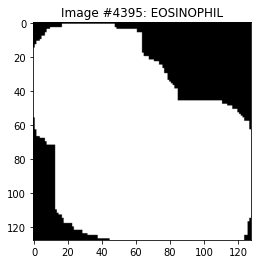

In [14]:
#hiển thị train image  
print(len(train_images))
index = np.random.randint(train_images.shape[0])
plt.figure()
plt.imshow(train_images[index])
plt.title('Image #{}: '.format(index) + class_names[train_labels[index]])
plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Ground Truth : 1')

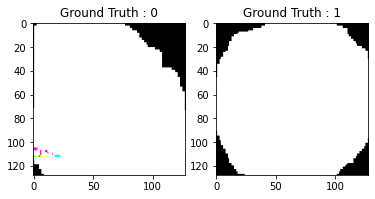

In [15]:
# Ground truth
# Hiển thị ảnh từ train data
plt.subplot(121)
index = np.random.randint(train_images.shape[0])
plt.imshow(train_images[index,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_labels[index]))

# Hiển thị ảnh từ test data
plt.subplot(122)
index = np.random.randint(test_images.shape[0])
plt.imshow(test_images[index,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_labels[index]))



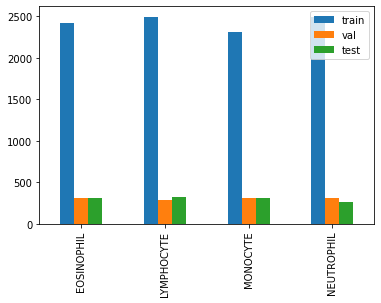

In [16]:
_, train_counts = np.unique(train_labels, return_counts = True)
_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()

plt.show()

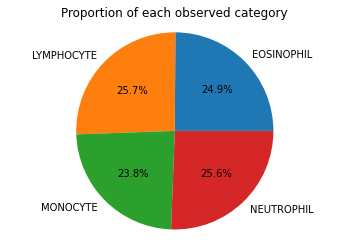

In [17]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9716


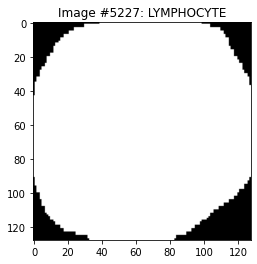

In [18]:
def display_random_image (class_names, images, labels):
    print(len(images))
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image (class_names, train_images, train_labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

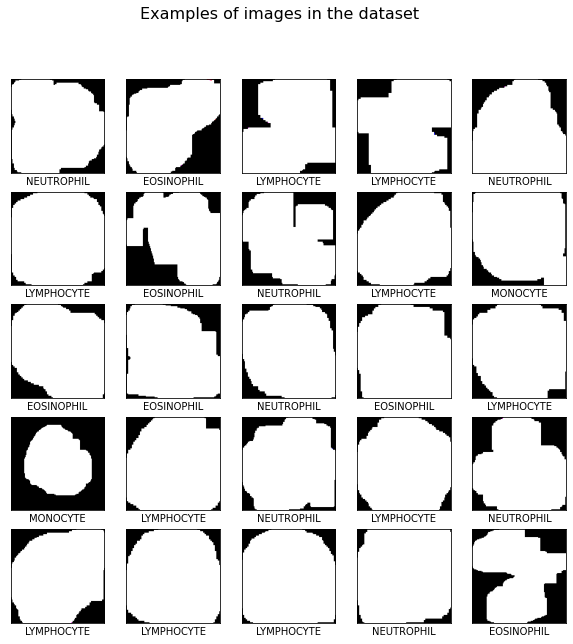

In [19]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

# ResNet50 Model


In [20]:
#Normalization
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

In [21]:
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

**Build Model** 

In [22]:
base_model = ResNet50(include_top=False,weights="imagenet")
base_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
__________________________

In [23]:
# số layer
print(len(base_model.layers))

175


In [24]:
# freeze N layers 
# thử 130/140/150 layers
for layer in base_model.layers[:140]:
    layer.trainable = False
    
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [25]:
model = keras.Sequential()

model.add(layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(layers.Lambda(keras.applications.resnet50.preprocess_input))
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(4,activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128, 128, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 14,986,244
Non-trainable params: 8,609,664
_________________________________________________________________


In [26]:
model.compile(optimizer = "adam" , 
               loss = 'sparse_categorical_crossentropy' , 
               metrics = ['accuracy'])
# model.summary()

callback1 = ModelCheckpoint(filepath='best_model.hdf5', save_best_only=True, save_weights_only=False)
callback2 = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
callback3 = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

historyResNet = model.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = EPOCHS, 
    validation_data=(val_images, val_labels), 
    callbacks=[callback1, callback3]
    )

Epoch 1/50
304/304 [==============================] - 80s 154ms/step - loss: 1.1574 - accuracy: 0.5093 - val_loss: 23.4460 - val_accuracy: 0.2321


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
304/304 [==============================] - 44s 144ms/step - loss: 0.9018 - accuracy: 0.6080 - val_loss: 2.7916 - val_accuracy: 0.3984
Epoch 3/50
304/304 [==============================] - 46s 150ms/step - loss: 0.7927 - accuracy: 0.6570 - val_loss: 4.6353 - val_accuracy: 0.3021
Epoch 4/50
304/304 [==============================] - 44s 145ms/step - loss: 0.7376 - accuracy: 0.6810 - val_loss: 3.2478 - val_accuracy: 0.4082
Epoch 5/50
304/304 [==============================] - 44s 144ms/step - loss: 0.6680 - accuracy: 0.7125 - val_loss: 1.7322 - val_accuracy: 0.4584
Epoch 6/50
304/304 [==============================] - 44s 144ms/step - loss: 0.6434 - accuracy: 0.7256 - val_loss: 1.1474 - val_accuracy: 0.5984
Epoch 7/50
304/304 [==============================] - 44s 144ms/step - loss: 0.5949 - accuracy: 0.7502 - val_loss: 8.5199 - val_accuracy: 0.2905
Epoch 8/50
304/304 [==============================] - 44s 144ms/step - loss: 0.5729 - accuracy: 0.7589 - val_loss: 2.0921 - val_ac

In [27]:
# historyResNet = model.fit(
#     train_images, 
#     train_labels, 
#     batch_size = 32, 
#     epochs = 50, 
#     validation_data=(val_images, val_labels), 
#     callbacks=[callback1, callback3]
#     )

In [28]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(EPOCHS)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()


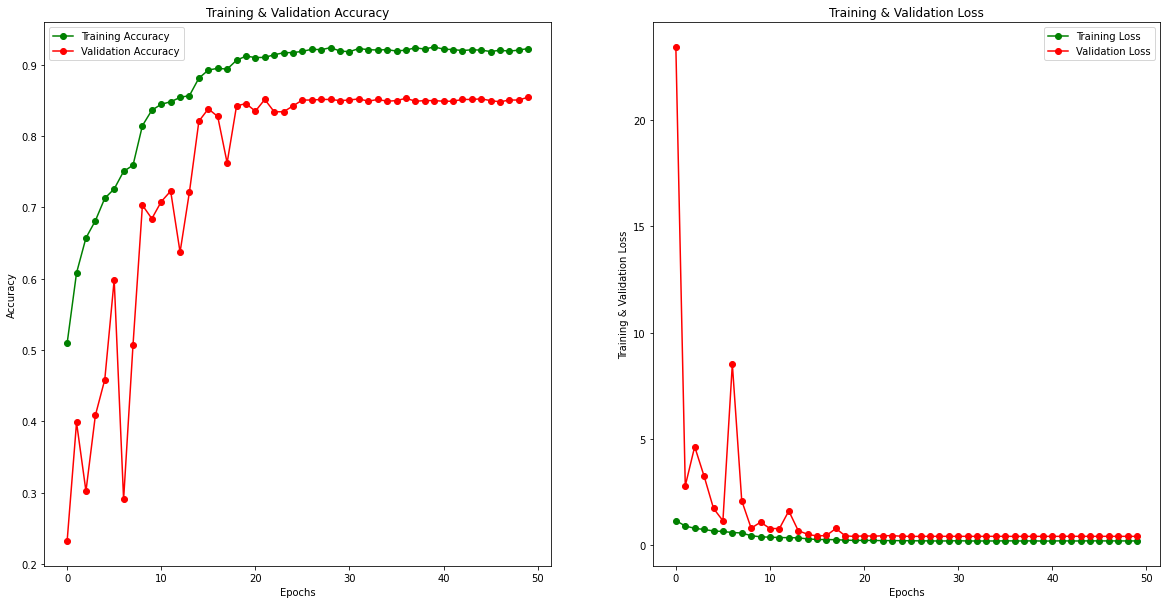

In [30]:
plot_accuracy_loss_chart(historyResNet)

In [32]:
results = model.evaluate(test_images, test_labels)

print("Loss of test model is  ", results[0])
print("Accuracy of test model is ", results[1]*100, "%")


results = model.evaluate(val_images, val_labels)

print("Loss of validation model is ", results[0])
print("Accuracy of validation model is ", results[1]*100, "%")

results = model.evaluate(train_images, train_labels)

print("Loss of train model  is ", results[0])
print("Accuracy of train model is ", results[1]*100, "%")

38/38 [==============================] - 4s 92ms/step - loss: 0.4439 - accuracy: 0.8420
Loss of test model is   0.4439128637313843
Accuracy of test model is  84.19753313064575 %
38/38 [==============================] - 3s 91ms/step - loss: 0.4134 - accuracy: 0.8543
Loss of validation model is  0.41335201263427734
Accuracy of validation model is  85.43210029602051 %
304/304 [==============================] - 28s 92ms/step - loss: 0.1521 - accuracy: 0.9432
Loss of train model  is  0.15205568075180054
Accuracy of train model is  94.31865215301514 %


In [ ]:
# Resnet50.save('/content/drive/MyDrive/BME2/Bloodcell_Classification_Resnet50_Custom_Build_10_epochs.h5')

In [34]:
from sklearn.metrics import classification_report

predictions = model.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

array([0, 2, 1, 1, 2, 2, 3, 1, 0, 1, 0, 0, 1, 0, 0])

In [35]:
print(classification_report(
    test_labels, 
    predictions, 
    target_names = ['EOSINOPHIL (Nhom 0)', 'LYMPHOCYTE (Nhom 1)', 'MONOCYTE (Nhom 2)', 'NEUTROPHIL (Nhom 3)']))

                     precision    recall  f1-score   support

EOSINOPHIL (Nhom 0)       0.78      0.71      0.74       313
LYMPHOCYTE (Nhom 1)       0.95      0.97      0.96       326
  MONOCYTE (Nhom 2)       0.86      0.90      0.88       312
NEUTROPHIL (Nhom 3)       0.75      0.78      0.76       264

           accuracy                           0.84      1215
          macro avg       0.84      0.84      0.84      1215
       weighted avg       0.84      0.84      0.84      1215



In [36]:
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])
cm

,0,1,2,3
0,222,10,23,58
1,5,316,4,1
2,21,2,280,9
3,38,3,18,205


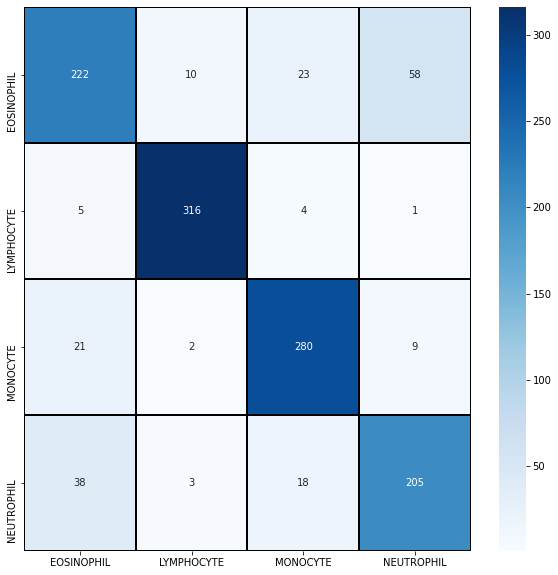

In [37]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)